In [1]:

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import plotly_express as px
import plotly
import shapely.geometry
from shapely.geometry import mapping
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
from scipy import spatial

import requests, io, json
import numpy as np
import itertools
import plotly.express as px


In [2]:

icesat = '/home/jovyan/exchange/4_Validation/Belize_cross.shp'
icesat = gpd.read_file(icesat)

df = pd.DataFrame(icesat)
df.head(2)


,depth,x,y,srf,weak beam,high noise,date,track_key,ATL03 fold,ml_name,geometry
0,-7.091346,407823.737707,1.848143e+06,-4.290219,0,1,20190716,gt3l,20190716T081144,stacked_lstm_model_v1.h5,POINT (407823.7377073572 1848143.372475534)
1,-7.165081,407823.233969,1.848149e+06,-4.290361,0,1,20190716,gt3l,20190716T081144,stacked_lstm_model_v1.h5,POINT (407823.2339687627 1848149.051995451)


# 1) Plot All Lines

A) Point Dataframe and interactive plots

Number of lines: 7


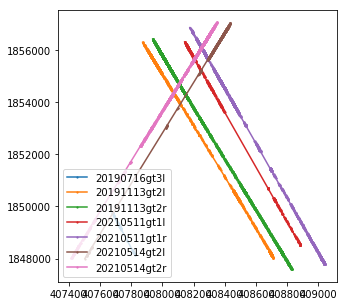

'scatters.html'

In [3]:
# Create a New ID Column
df = pd.DataFrame(icesat)
df['ID'] = df['date'].astype(str) + df['track_key']
groups = df.groupby('ID')[['x','y']]
print("Number of lines:",len(groups))

# Plot All Lines

fig, ax = plt.subplots(figsize=(5,5))
for track, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='-', ms=1.2, label=track)
ax.legend()
plt.show()

# Interactive plots
fig = px.line(df, x='x', y='y', color='ID')
plotly.offline.plot(fig, filename='lines.html')

fig = px.scatter(df, x='x', y='y', color='ID',hover_name='depth')
plotly.offline.plot(fig, filename='scatters.html')


,geometry
ID,
20190716gt3l,LINESTRING (407823.7377073572 1848143.37247553...
20191113gt2l,LINESTRING (408712.5939629879 1848011.16351522...
20191113gt2r,LINESTRING (408830.6177334277 1847580.12644292...
20210511gt1l,LINESTRING (408885.8694441452 1848505.56922336...
20210511gt1r,LINESTRING (409040.8149347508 1847787.72973273...
20210514gt2l,LINESTRING (408436.041626818 1857046.877504785...
20210514gt2r,LINESTRING (408349.3293149121 1857070.35901761...


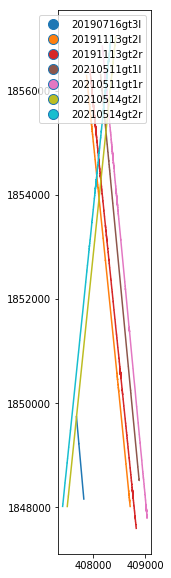

In [4]:
# Zip the coordinates into a point object and convert to a GeoDataFrame

df = pd.DataFrame(icesat)

geometry = [Point(xy) for xy in zip(df.x, df.y)]
df = GeoDataFrame(df, geometry=geometry)
df['ID'] = df['date'].astype(str) + df['track_key']

# Aggregate these points with the GroupBy
df = df.groupby(['ID'])['geometry'].apply(lambda x: LineString(x.tolist()))
gdf_linestring = GeoDataFrame(df, geometry='geometry')

gdf_linestring.plot(column=gdf_linestring.index.values, figsize = (5,10), legend=True)

gdf_linestring


In [5]:
df = pd.DataFrame(icesat)

idxmin=df.groupby(by='ID')['x'].idxmin()
df_min=df.loc[idxmin,]

idxmax=df.groupby(by='ID')['x'].idxmax()
df_max=df.loc[idxmax,]

df_xy = df_min.merge(df_max, how='left', on='ID')
df_xy.head(3)

,depth_x,x_x,y_x,srf_x,weak beam_x,high noise_x,date_x,track_key_x,ATL03 fold_x,ml_name_x,...,x_y,y_y,srf_y,weak beam_y,high noise_y,date_y,track_key_y,ATL03 fold_y,ml_name_y,geometry_y
0,-11.818848,407679.882439,1.849754e+06,-4.330685,0,1,20190716,gt3l,20190716T081144,stacked_lstm_model_v1.h5,...,407823.737707,1.848143e+06,-4.290219,0,1,20190716,gt3l,20190716T081144,stacked_lstm_model_v1.h5,POINT (407823.7377073572 1848143.372475534)
1,-10.517933,407873.521093,1.856306e+06,-4.172466,1,0,20191113,gt2l,20191113T022751,stacked_lstm_model_v1.h5,...,408712.609110,1.848011e+06,-3.928495,1,0,20191113,gt2l,20191113T022751,stacked_lstm_model_v1.h5,POINT (408712.6091104901 1848011.162752594)
2,-10.591346,407938.145965,1.856428e+06,-4.059366,0,0,20191113,gt2r,20191113T022751,stacked_lstm_model_v1.h5,...,408830.617733,1.847580e+06,-3.786900,0,0,20191113,gt2r,20191113T022751,stacked_lstm_model_v1.h5,POINT (408830.6177334277 1847580.126442926)


In [6]:
df = pd.DataFrame(icesat)
gdf = gpd.GeoDataFrame(
    data=df_xy,
    geometry=df_xy.apply(
        lambda r: shapely.geometry.LineString([(r["x_x"], r["y_x"]),(r["x_y"], r["y_y"]) ]), axis=1)) 


# 2) Intersection

In [92]:
#Intersection

# Return true if line segments AB and CD intersect
def ccw(A,B,C):
    return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)


In [97]:

i=0
j=0
df_inter = pd.DataFrame(columns=['L1', 'L2', 'x_int','y_int'])

for index1, row1 in df_xy.iterrows():
    a1= Point(row1.x_x,row1.y_x)
    a2= Point(row1.x_y,row1.y_y)
    i+=1
    for index2, row2 in df_xy[i:].iterrows():
        b1= Point(row2.x_x,row2.y_x)
        b2= Point(row2.x_y,row2.y_y)
        if intersect(a1,a2,b1,b2)==True:
            j+=1
            x_int, y_int = get_intersect(a1,a2,b1,b2)
            df_inter.loc[j] = [row1.ID, row2.ID,x_int, y_int]
                            
df_inter  


,L1,L2,x_int,y_int
1,20190716gt3l,20210514gt2l,407681.877073,1.849731e+06
2,20191113gt2l,20210514gt2l,408114.292868,1.853926e+06
3,20191113gt2l,20210514gt2r,408070.137056,1.854362e+06
4,20191113gt2r,20210514gt2l,408152.814907,1.854300e+06
5,20191113gt2r,20210514gt2r,408108.723515,1.854737e+06
6,20210511gt1l,20210514gt2l,408247.516776,1.855218e+06
7,20210511gt1l,20210514gt2r,408204.741964,1.855668e+06
8,20210511gt1r,20210514gt2l,408292.178976,1.855651e+06
9,20210511gt1r,20210514gt2r,408249.381516,1.856101e+06


'scatters_inter.html'

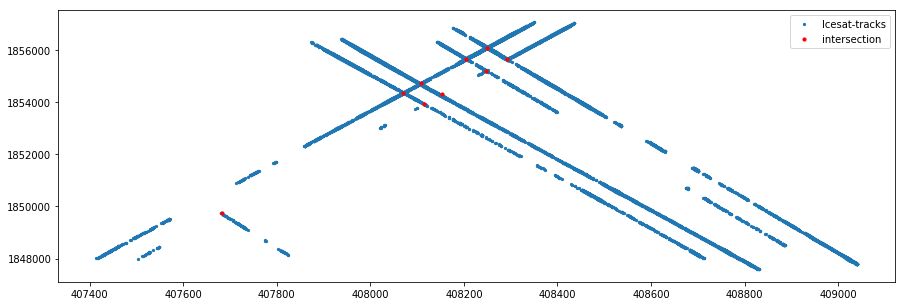

In [98]:

fig, ax = plt.subplots(figsize=(15, 5))

plt.scatter(df.x, df.y, label='Icesat-tracks',s=5)
plt.scatter(df_inter.x_int,df_inter.y_int, s=10 ,c='r', label='intersection')
plt.legend()

fig = px.scatter(df_inter, x='x_int', y='y_int', color='L1',hover_name='L2')
plotly.offline.plot(fig, filename='scatters_inter.html')


# 3) Icesat Closest Point from the Intersection Point

In [99]:

# Create geometries from your lat-lons
geom_list_intersection= [shapely.geometry.Point(lon,lat) for lon,lat in zip(df_inter["x_int"],df_inter["y_int"])] # check the ordering of lon/lat
geom_list_points = [shapely.geometry.Point(lon,lat) for lon,lat in zip(df["x"],df["y"])] # check the ordering of lon/lat

# create geopandas geodataframe
gdf_intersection = gpd.GeoDataFrame(df_inter, geometry=geom_list_intersection, crs={"init":"EPSG:4326"})
gdf_points = gpd.GeoDataFrame(df, geometry=geom_list_points, crs={"init":"EPSG:4326"})

print('Number of intersection:',len(gdf_intersection), 'Number of all icesat points:',len(gdf_points))


Number of intersection: 9 Number of all icesat points: 17873


In [100]:

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2),np.min(dist_2)

for index, row in df_inter.iterrows():
    L1_points = gdf_points[gdf_points['ID']== row.L1]
    points_all = [(x,y) for x,y in zip(L1_points.x , L1_points.y)]
    point = (row.x_int,row.y_int)
    a= closest_node(point, points_all)
    df_inter.at[index, 'L1_x'] = L1_points.iloc[[a[0]]].x.values
    df_inter.at[index, 'L1_y'] = L1_points.iloc[[a[0]]].y.values
    df_inter.at[index, 'Depth_L1'] = L1_points.iloc[[a[0]]].depth.values
    # df_inter.at[index, 'Dist_L1'] = a[1]

for index, row in df_inter.iterrows():
    L2_points = gdf_points[gdf_points['ID']== row.L2]
    points_all = [(x,y) for x,y in zip(L2_points.x , L2_points.y)]
    point = (row.x_int,row.y_int)
    a= closest_node(point, points_all)
    df_inter.at[index, 'L2_x'] = L2_points.iloc[[a[0]]].x.values
    df_inter.at[index, 'L2_y'] = L2_points.iloc[[a[0]]].y.values
    df_inter.at[index, 'Depth_L2'] = L2_points.iloc[[a[0]]].depth.values
    # df_inter.at[index, 'Dist_L2'] = a[1]
    
for index, row in df_inter.iterrows():
    L2_points = gdf_points[gdf_points['ID']== row.L2]
    points_all = [(x,y) for x,y in zip(df_inter.L1_x , df_inter.L1_y)]
    point = (row.x_int,row.y_int)
    a= closest_node(point, points_all)
    #df_inter.at[index, 'Depth_L2'] = L2_points.iloc[[a[0]]].depth.values
    df_inter.at[index, 'Dist_L1L2'] = a[1]  
    
df_inter['Depth_dif'] = (df_inter.Depth_L1-df_inter.Depth_L2)
df_inter['Lines'] = df_inter['L1'].astype(str) + ' ' +df_inter['L2']

#df_inter['Dist_dif'] = abs(df_inter.Dist_L1-df_inter.Dist_L2)


df_inter


,L1,L2,x_int,y_int,geometry,L1_x,L1_y,Depth_L1,L2_x,L2_y,Depth_L2,Dist_L1L2,Depth_dif,Lines
1,20190716gt3l,20210514gt2l,407681.877073,1.849731e+06,POINT (407681.8770728683 1849731.292479794),407681.852494,1.849733e+06,-11.404136,407549.126120,1.848444e+06,-8.269665,1.730542,-3.134471,20190716gt3l 20210514gt2l
2,20191113gt2l,20210514gt2l,408114.292868,1.853926e+06,POINT (408114.2928680688 1853925.83397524),408116.269637,1.853923e+06,-6.128696,408100.626709,1.853790e+06,-6.667881,12.377029,0.539185,20191113gt2l 20210514gt2l
3,20191113gt2l,20210514gt2r,408070.137056,1.854362e+06,POINT (408070.1370557662 1854362.33743917),408071.672990,1.854360e+06,-4.768061,408070.306261,1.854362e+06,-4.606005,8.031520,-0.162056,20191113gt2l 20210514gt2r
4,20191113gt2r,20210514gt2l,408152.814907,1.854300e+06,POINT (408152.8149072339 1854299.507401512),408147.460827,1.854299e+06,-2.109260,408100.626709,1.853790e+06,-6.667881,28.943656,4.558621,20191113gt2r 20210514gt2l
5,20191113gt2r,20210514gt2r,408108.723515,1.854737e+06,POINT (408108.7235152794 1854736.60628645),408103.849659,1.854736e+06,-2.277930,408108.439221,1.854737e+06,-2.623408,24.236148,0.345479,20191113gt2r 20210514gt2r
6,20210511gt1l,20210514gt2l,408247.516776,1.855218e+06,POINT (408247.5167762767 1855218.139245688),408247.641946,1.855216e+06,-4.437508,408247.730073,1.855217e+06,-4.704376,4.441234,0.266868,20210511gt1l 20210514gt2l
7,20210511gt1l,20210514gt2r,408204.741964,1.855668e+06,POINT (408204.7419640232 1855667.935944117),408204.642578,1.855669e+06,-1.711936,408203.967933,1.855668e+06,-1.633783,1.504402,-0.078152,20210511gt1l 20210514gt2r
8,20210511gt1r,20210514gt2l,408292.178976,1.855651e+06,POINT (408292.1789762444 1855651.373769314),408292.370842,1.855653e+06,-0.885537,408292.448414,1.855651e+06,-1.253818,2.970657,0.368280,20210511gt1r 20210514gt2l
9,20210511gt1r,20210514gt2r,408249.381516,1.856101e+06,POINT (408249.3815163099 1856100.916683688),408249.962042,1.856101e+06,-1.045951,408248.782102,1.856101e+06,-1.426765,0.397802,0.380814,20210511gt1r 20210514gt2r


# 4) Plot

In [110]:

df_inter_final = df_inter[df_inter['Dist_L1L2']<10000]
print(len(df_inter_final))

fig = px.scatter(df_inter_final, x='Dist_L1L2', y='Depth_L2',hover_name='Lines')
plotly.offline.plot(fig, filename='Icesat_Dif.html')


df_inter_final



9


,L1,L2,x_int,y_int,geometry,L1_x,L1_y,Depth_L1,L2_x,L2_y,Depth_L2,Dist_L1L2,Depth_dif,Lines
1,20190716gt3l,20210514gt2l,407681.877073,1.849731e+06,POINT (407681.8770728683 1849731.292479794),407681.852494,1.849733e+06,-11.404136,407549.126120,1.848444e+06,-8.269665,1.730542,-3.134471,20190716gt3l 20210514gt2l
2,20191113gt2l,20210514gt2l,408114.292868,1.853926e+06,POINT (408114.2928680688 1853925.83397524),408116.269637,1.853923e+06,-6.128696,408100.626709,1.853790e+06,-6.667881,12.377029,0.539185,20191113gt2l 20210514gt2l
3,20191113gt2l,20210514gt2r,408070.137056,1.854362e+06,POINT (408070.1370557662 1854362.33743917),408071.672990,1.854360e+06,-4.768061,408070.306261,1.854362e+06,-4.606005,8.031520,-0.162056,20191113gt2l 20210514gt2r
4,20191113gt2r,20210514gt2l,408152.814907,1.854300e+06,POINT (408152.8149072339 1854299.507401512),408147.460827,1.854299e+06,-2.109260,408100.626709,1.853790e+06,-6.667881,28.943656,4.558621,20191113gt2r 20210514gt2l
5,20191113gt2r,20210514gt2r,408108.723515,1.854737e+06,POINT (408108.7235152794 1854736.60628645),408103.849659,1.854736e+06,-2.277930,408108.439221,1.854737e+06,-2.623408,24.236148,0.345479,20191113gt2r 20210514gt2r
6,20210511gt1l,20210514gt2l,408247.516776,1.855218e+06,POINT (408247.5167762767 1855218.139245688),408247.641946,1.855216e+06,-4.437508,408247.730073,1.855217e+06,-4.704376,4.441234,0.266868,20210511gt1l 20210514gt2l
7,20210511gt1l,20210514gt2r,408204.741964,1.855668e+06,POINT (408204.7419640232 1855667.935944117),408204.642578,1.855669e+06,-1.711936,408203.967933,1.855668e+06,-1.633783,1.504402,-0.078152,20210511gt1l 20210514gt2r
8,20210511gt1r,20210514gt2l,408292.178976,1.855651e+06,POINT (408292.1789762444 1855651.373769314),408292.370842,1.855653e+06,-0.885537,408292.448414,1.855651e+06,-1.253818,2.970657,0.368280,20210511gt1r 20210514gt2l
9,20210511gt1r,20210514gt2r,408249.381516,1.856101e+06,POINT (408249.3815163099 1856100.916683688),408249.962042,1.856101e+06,-1.045951,408248.782102,1.856101e+06,-1.426765,0.397802,0.380814,20210511gt1r 20210514gt2r


# Old

In [ ]:
points = [(x,y) for x,y in zip(gdf_points.x , gdf_points.y)]
points = np.asarray(points)
tree = spatial.cKDTree(points)
plt.plot(points[:,0], points[:,1], '.')



In [ ]:


for results in tree.query_ball_point(coord_list, 1):
    print(results)
    nearby_points = points[results]
    plt.plot(nearby_points[:,0], nearby_points[:,1], 'o')
plt.margins(0.1, 0.1)
plt.show()



In [ ]:
import matplotlib.pyplot as plt
points = points
plt.plot(points[:,0], points[:,1], '.')
for results in tree.query_ball_point(([2, 0], [3, 3]), 1):
    nearby_points = points[results]
    plt.plot(nearby_points[:,0], nearby_points[:,1], 'o')
plt.margins(0.1, 0.1)
plt.show()



In [30]:
def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return nodes[closest_index]


In [ ]:
from shapely.geometry import LineString

line = LineString([(0, 0), (1, 1)])
other = LineString([(0, 1), (1, 0)])
print(line.intersects(other))
# True

In [ ]:
#
# line segment intersection using vectors
# see Computer Graphics by F.S. Hill
#
from numpy import *
def perp( a ) :
    b = empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = dot( dap, db)
    num = dot( dap, dp )
    return (num / denom.astype(float))*db + b1

p1 = array((407414.349882, 1.848002e+06))
p2 = array((408349.329315, 1.857070e+06))

p3 = array((408176.137153, 1.848000e+06))
p4 = array((408436.041627,1.857047e+06))

print (seg_intersect( p1,p2, p3,p4))

p1 = array( (407414.349882, 1.848002e+06) )
p2 = array( (408349.329315, 1.857070e+06) )

p3 = array( (407503.365959	, 1.848143e+06) )
p4 = array( (407823.737707,1.849754e+06) )

print(seg_intersect( p1,p2, p3,p4))

In [ ]:
# A Python3 program to find if 2 given line segments intersect or not

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Given three collinear points p, q, r, the function checks if 
# point q lies on line segment 'pr' 
def onSegment(p, q, r):
    if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and 
           (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))):
        return True
    return False

def orientation(p, q, r):
    # to find the orientation of an ordered triplet (p,q,r)
    # function returns the following values:
    # 0 : Collinear points
    # 1 : Clockwise points
    # 2 : Counterclockwise
    
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/amp/ 
    # for details of below formula. 
    
    val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y))
    if (val > 0):
        
        # Clockwise orientation
        return 1
    elif (val < 0):
        
        # Counterclockwise orientation
        return 2
    else:
        
        # Collinear orientation
        return 0

# The main function that returns true if 
# the line segment 'p1q1' and 'p2q2' intersect.
def doIntersect(p1,q1,p2,q2):
    
    # Find the 4 orientations required for 
    # the general and special cases
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True

    # Special Cases

    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and onSegment(p1, p2, q1)):
        return True

    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and onSegment(p1, q2, q1)):
        return True

    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and onSegment(p2, p1, q2)):
        return True

    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and onSegment(p2, q1, q2)):
        return True

    # If none of the cases
    return False

# Driver program to test above functions:
p1 = Point(407414.349882, 1.848002e+06)
q1 = Point(408349.329315, 1.857070e+06)

p2 = Point(408176.137153, 1.848000e+06)
q2 = Point(408436.041627,1.857047e+06)

if doIntersect(p1, q1, p2, q2):
    print("Yes")
else:
    print("No")

p1 = Point(10, 0)
q1 = Point(0, 10)
p2 = Point(0, 0)
q2 = Point(10,10)

if doIntersect(p1, q1, p2, q2):
    print("Yes")
else:
    print("No")

p1 = Point(-5,-5)
q1 = Point(0, 0)
p2 = Point(1, 1)
q2 = Point(10, 10)

if doIntersect(p1, q1, p2, q2):
    print("Yes")
else:
    print("No")
    
# This code is contributed by Ansh Riyal


In [ ]:

# print LineString coordinates
g = [i for i in gdf_linestring.geometry]
f = len(g)

all_data = []
for i in range(f):
    geojson_ob = mapping(g[i])
    geojson_ob 

from itertools import combinations

for line1, line2 in combinations([line for line in all_coords],2):
    if line1.intersects(line2):
        print(line1.intersection(line2))

# 2) Intersections

*pandas.core.frame.DataFrame*

In [ ]:

# print LineString coordinates
g = [i for i in gdf.geometry]
geojson_ob = mapping(g[0]) # for first feature/row
all_coords = geojson_ob["coordinates"]
all_coords


In [ ]:
df = pd.DataFrame(icesat)
df['ID'] = df['date'].astype(str) + df['track_key']

groups_max = df.groupby('ID')[['x']].max()
groups_max = groups_max.rename(columns={'x': 'x_max','y': 'y_max'})


groups_min = df.groupby('ID')[['x']].min()


groups_min = groups_min.rename(columns={'x': 'x_min','y': 'y_min'})

df_xy = groups_min.merge(groups_max, how='left', on='ID')


In [ ]:
def get_intersection_np(arr: np.ndarray):
    means = np.mean(arr, axis=0)
    indices = np.all(means == arr, axis=0)
    return [i for i, bool_ in enumerate(indices) if bool_]

In [ ]:
icesat = '/home/jovyan/exchange/4_Validation/Belize_cross.shp'
icesat = gpd.read_file(icesat)

df = pd.DataFrame(icesat)
df.head(4)

df['ID'] = df['date'].astype(str) + df['track_key']

b = []

groups = df.groupby('ID')
for track, group in groups:
    group.loc[(group['ID'] == track)]
    a = group.loc[(group['x'] == group['x'].min())]
    b.append(a)



In [ ]:
# groupby columns on Col1 and estimate the minimum value of column Col2 for each group
#df.groupby(['ID'])['x'].min()
# alternatively, you can pass 'min' to the agg() function
df.groupby('ID')['x'].agg('min')


In [ ]:
# Create an empty list
my_list =[]

for track, group in groups:
    a = group.loc[(group['x'] == group['x'].min())]

    my_list.append(groups.get_group(track))
 

In [ ]:
for index, row in gdf.iterrows():
    print(row['x_min'],row['y_min'], row['x_max'],row['y_max'])
    intersection =  seg_intersect(row['x_min'],row['y_min'], row['x_max'],row['y_max'])
    print(intersection)

In [ ]:
from numpy import *